<a href="https://colab.research.google.com/github/nohasamir89/noha_project/blob/main/TM_vec_Noha_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
%pip install git+https://github.com/tymor22/tm-vec.git -q gwpy
%pip install -q SentencePiece transformers
%pip install faiss-cpu

# Import libraries
import torch
from transformers import T5EncoderModel, T5Tokenizer
import numpy as np
import pandas as pd
from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec, encode
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 65.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

def get_file_path():
    drive.mount('/content/drive')

    print("\nNavigate through your Google Drive folders:")
    current_path = "/content/drive/My Drive"

    while True:
        print(f"\nCurrent directory: {current_path}")
        print("\nContents:")
        contents = sorted(os.listdir(current_path))
        for i, item in enumerate(contents):
            print(f"{i}: {item}")

        choice = input("\nEnter number to open folder, 'p' for parent directory, or 'x' to select current directory: ")

        if choice.lower() == 'x':
            return current_path
        elif choice.lower() == 'p':
            current_path = os.path.dirname(current_path)
        elif choice.isdigit() and int(choice) < len(contents):
            selected = contents[int(choice)]
            new_path = os.path.join(current_path, selected)
            if os.path.isdir(new_path):
                current_path = new_path
            else:
                print(f"\nSelected file path: {new_path}")
                return new_path
        else:
            print("Invalid choice, try again")

# Use the function to find your files
print("Let's locate your first file (interacting pairs):")
interacting_path = get_file_path()
print("\nNow let's locate your second file (non-interacting pairs):")
non_interacting_path = get_file_path()

print(f"\nFound paths:")
print(f"Interacting pairs file: {interacting_path}")
print(f"Non-interacting pairs file: {non_interacting_path}")

In [8]:
# Load tokenizer and ProtT5 model
print("Loading ProtT5 tokenizer and model...")
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

# Set up device (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
model = model.eval()

# Let's use the interactive file picker to locate your model files
print("\nPlease locate tm_vec_cath_model_params.json:")
params_path = get_file_path()

print("\nPlease locate tm_vec_cath_model.ckpt:")
model_path = get_file_path()

# Load TM-Vec model
print("Loading TM-Vec model...")
tm_vec_model_config = trans_basic_block_Config.from_json(params_path)
model_deep = trans_basic_block.load_from_checkpoint(model_path, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

print("All models loaded successfully!")

Loading ProtT5 tokenizer and model...
Using device: cpu

Please locate tm_vec_cath_model_params.json:
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Navigate through your Google Drive folders:

Current directory: /content/drive/My Drive

Contents:
0: 044cba792be71062c631a4dcbd23a836.pdf
1: 05_01.pptx
2: 1-s2.0-S0012160616306935-main.pdf
3: 1-s2.0-S0890623821001301-main.pdf
4: 1-s2.0-S0896627317302866-main.pdf
5: 1-s2.0-S1567133X19300638-main.pdf
6: 1148.full.pdf
7: 2021.03.21.436320v1.full.pdf
8: 22708126
9: 231018_list of all samples for sequencing.xlsx
10: 4199.pdf
11: 6361132.epub
12: AD1.pdf
13: AD2.pdf
14: AD3.pdf
15: Aims_draft.gdoc
16: Aims_ppt.gslides
17: Aitken et al 2020.pdf
18: Amhed
19: Atomic habits ( PDFDrive ).pdf
20: B1XaNSP_01.txt
21: B1XaNSP_02.txt
22: B1XaNSP_03.txt
23: B1XdTom_01.txt
24: B1XdTom_02.txt
25: B1XdTom_03.txt
26: B1aNSP_01.txt
27: B1aNSP_02.txt
28: B1aNSP_03.txt
29: B1dTom

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/My Drive/tm_vec_cath_model.ckpt`


All models loaded successfully!


In [10]:
# Load your data
print("Loading protein pair data...")
interacting_pairs = pd.read_csv(interacting_path)
non_interacting_pairs = pd.read_csv(non_interacting_path)

# Check the column names
print("\nInteracting pairs columns:", interacting_pairs.columns.tolist())
print("Non-interacting pairs columns:", non_interacting_pairs.columns.tolist())

# Display first few rows of each dataframe
print("\nFirst few rows of interacting pairs:")
print(interacting_pairs.head())
print("\nFirst few rows of non-interacting pairs:")
print(non_interacting_pairs.head())

Loading protein pair data...

Interacting pairs columns: ['MNTRKKNPKRGVGKTETNTEWLDKVINQLINKDFSQYL', 'MKLRLFEFYFIKDYLRPWFGLIYSLFFLFFLGAIGYRITEGWDWGDCLWMVLITITTIGFGEVQTLSPEGRIITVLIIVGGLIFIQFTFQKAVRLFESGYFQRVNELRFKRLLRKMENHVILCGYGRVGQEISNQIKTQNIPIIVVESDEDRKKIAEDNGLEVLCADATLDETLKLAGLDKCKSLVVTLPNDAANLYVVLSAKGIRSSIRVIARAGTEEAASKLRLAGASIVVSPYIAAGRAMASMALRPIAIDFLDLLAGSECEIEEFELSNDISLFETAEKITLLELGIGKKSGAKILAIKEDEKLITNPGGDFLLQPGQVLIAFGSKEQLTTLNRLLGNLVVSVELLK']
Non-interacting pairs columns: ['LSKRNPIILIHGLWNTADIFSSITSKLDEIGIEYFSPTLKHEYGMTSIVELTNLLNYLILEKYGYEKELDILGFSMGGIIGRYWIKKLNGYKRTRRFITIGSPHNGTLSSQLIPKYPFKGISEMKINSPLLRELSRSDYLLSGIDCISFFTYWDLMVFPGWRACLNSGEKISLKIYKHKNLVRNPDAVDKIIEKLLN', 'VRNSPFLPNRPLKVAVLGSSGAVGSELLKILEERDFPISELVLLSSQRSEGKIVKWKGEEIITKKASKEEFLNVDLVLASAGGSISKQWLSTVKDQNAVLIDNSSAFRLENDVPLVVPEVNACEALKHNGVIANPNCTTILLTLVLAPLNKISPIKRVIVSTYQSVSGAGQLAMEELQFLTKKYLQGDPKESEVLPYSLAFNLFLHNSPMLSNNYCEEEMKMTNETRKILNITDLKLSSTCVRVPVLRAHSESVNVEFDDVIKPSYAINQLKKAKGLEIIEDYEKNRFPMPNDVMGRDNIAVGRIRTDISN


Processing interacting protein pairs...
Processing 100 pairs...
Processing pair 1/100


100%|██████████| 1/1 [00:10<00:00, 10.00s/it]


Processing pair 11/100


100%|██████████| 1/1 [00:09<00:00,  9.34s/it]


Processing pair 21/100


100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


Processing pair 31/100


100%|██████████| 1/1 [00:16<00:00, 16.65s/it]


Processing pair 41/100


100%|██████████| 1/1 [00:16<00:00, 16.66s/it]


Processing pair 51/100


100%|██████████| 1/1 [00:15<00:00, 15.08s/it]


Processing pair 61/100


100%|██████████| 1/1 [00:07<00:00,  7.39s/it]


Processing pair 71/100


100%|██████████| 1/1 [00:05<00:00,  5.25s/it]


Processing pair 81/100


100%|██████████| 1/1 [00:17<00:00, 17.76s/it]


Processing pair 91/100


100%|██████████| 1/1 [00:20<00:00, 20.88s/it]


Completed 100 interacting pairs

Processing non-interacting protein pairs...
Processing 100 pairs...
Processing pair 1/100


100%|██████████| 1/1 [00:16<00:00, 16.73s/it]


Processing pair 11/100


100%|██████████| 1/1 [00:05<00:00,  5.33s/it]


Processing pair 21/100


100%|██████████| 1/1 [00:33<00:00, 33.29s/it]


Processing pair 31/100


100%|██████████| 1/1 [00:11<00:00, 11.67s/it]


Processing pair 41/100


100%|██████████| 1/1 [00:12<00:00, 12.74s/it]


Processing pair 51/100


100%|██████████| 1/1 [01:32<00:00, 92.32s/it]


Processing pair 61/100


100%|██████████| 1/1 [00:20<00:00, 20.09s/it]


Processing pair 71/100


100%|██████████| 1/1 [00:09<00:00,  9.69s/it]


Processing pair 81/100


100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


Processing pair 91/100


100%|██████████| 1/1 [00:11<00:00, 11.80s/it]


Completed 100 non-interacting pairs

Creating t-SNE visualization...


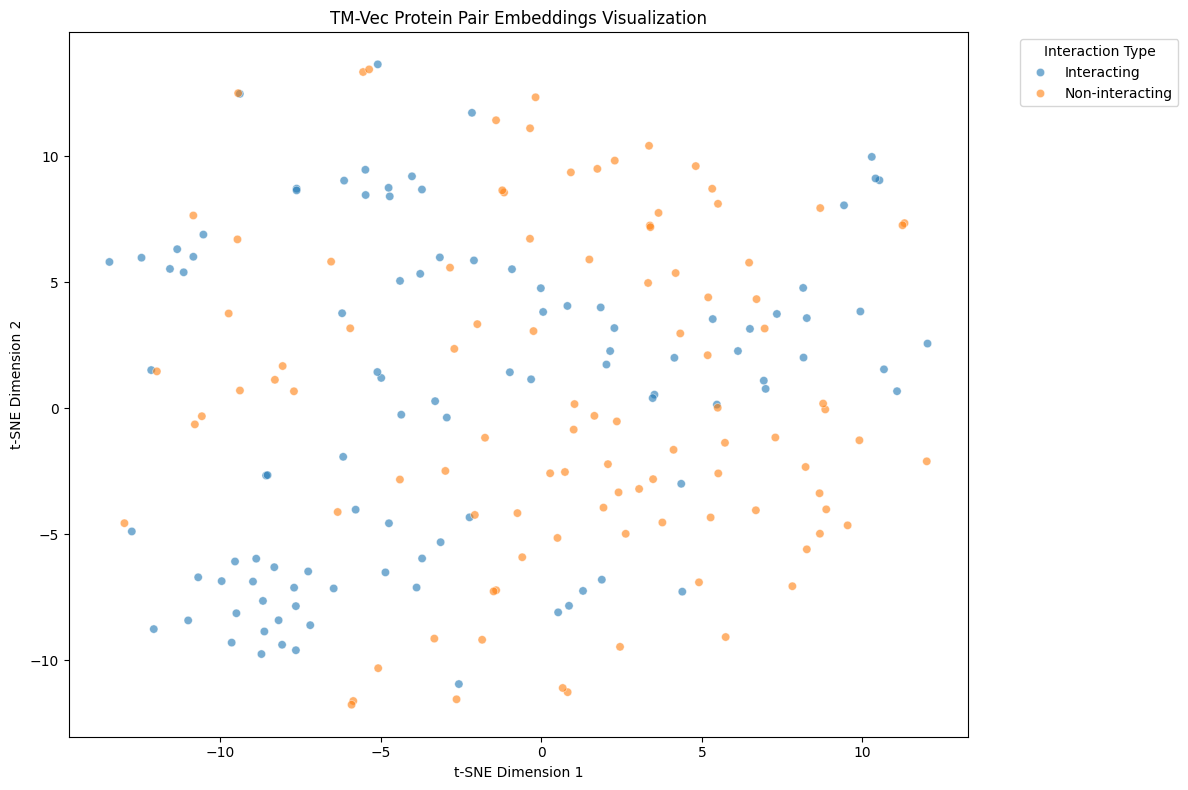

In [14]:
def process_protein_pairs(df):
    pair_embeddings = []
    seq1_name = df.columns[0]
    seq2_name = df.columns[1]

    print(f"Processing {len(df)} pairs...")

    # Process each pair
    for index, row in df.iterrows():
        if index % 10 == 0:  # Progress update
            print(f"Processing pair {index + 1}/{len(df)}")

        # Get the two protein sequences for this pair
        protein1 = row[seq1_name]
        protein2 = row[seq2_name]

        # Calculate TM-Vec embedding for this specific pair
        embedding1 = encode([protein1], model_deep, model, tokenizer, device)[0]
        embedding2 = encode([protein2], model_deep, model, tokenizer, device)[0]

        # Combine the embeddings for this pair
        pair_embedding = np.concatenate([embedding1, embedding2])
        pair_embeddings.append(pair_embedding)

    return np.array(pair_embeddings)

# Process interacting pairs
print("\nProcessing interacting protein pairs...")
interacting_embeddings = process_protein_pairs(interacting_pairs)
print(f"Completed {len(interacting_embeddings)} interacting pairs")

# Process non-interacting pairs
print("\nProcessing non-interacting protein pairs...")
non_interacting_embeddings = process_protein_pairs(non_interacting_pairs)
print(f"Completed {len(non_interacting_embeddings)} non-interacting pairs")

# Combine all embeddings
all_pair_embeddings = np.vstack([interacting_embeddings, non_interacting_embeddings])
labels = ['Interacting'] * len(interacting_embeddings) + ['Non-interacting'] * len(non_interacting_embeddings)

# Save the results
save_dir = os.path.dirname(interacting_path)
np.save(os.path.join(save_dir, 'protein_pair_embeddings.npy'), all_pair_embeddings)
np.save(os.path.join(save_dir, 'pair_labels.npy'), labels)

# Create t-SNE visualization
print("\nCreating t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
pair_tsne = tsne.fit_transform(all_pair_embeddings)

# Create visualization dataframe
tsne_df = pd.DataFrame(pair_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Interaction'] = labels

# Create the plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Interaction', alpha=0.6)
plt.title('TM-Vec Protein Pair Embeddings Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Add legend with a better location
plt.legend(title='Interaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

# Print embedding statistics
print("\nEmbedding Statistics:")
print(f"Number of interacting pairs: {len(interacting_embeddings)}")
print(f"Number of non-interacting pairs: {len(non_interacting_embeddings)}")
print(f"Embedding dimension for each pair: {all_pair_embeddings.shape[1]}")

Creating t-SNE visualization with new parameters...


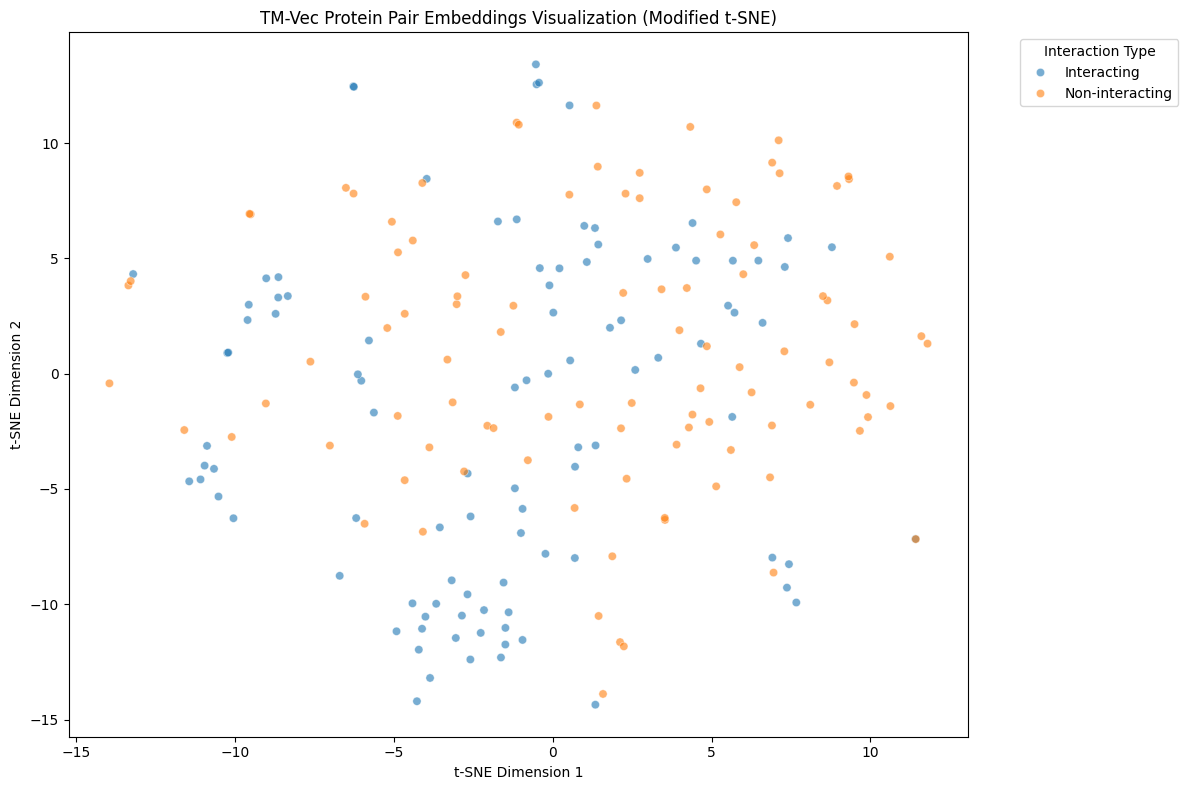


Embedding Statistics:
Number of pairs: 200
Embedding dimension: 1024
Number of interacting pairs: 100
Number of non-interacting pairs: 100


In [15]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the saved embeddings and labels
save_dir = os.path.dirname(interacting_path)
all_pair_embeddings = np.load(os.path.join(save_dir, 'protein_pair_embeddings.npy'))
labels = np.load(os.path.join(save_dir, 'pair_labels.npy'))

# Ensure embeddings are numpy array
if not isinstance(all_pair_embeddings, np.ndarray):
    all_pair_embeddings = all_pair_embeddings.detach().cpu().numpy()

# Create t-SNE with specified parameters
print("Creating t-SNE visualization with new parameters...")
sequence_tsne = TSNE(
    n_components=2,
    learning_rate='auto',
    init='random',
    random_state=42
).fit_transform(all_pair_embeddings)

# Create visualization dataframe
tsne_df = pd.DataFrame(sequence_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Interaction'] = labels

# Create the plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Interaction', alpha=0.6)
plt.title('TM-Vec Protein Pair Embeddings Visualization (Modified t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Add legend with a better location
plt.legend(title='Interaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

# Print some basic statistics about the embeddings
print("\nEmbedding Statistics:")
print(f"Number of pairs: {len(all_pair_embeddings)}")
print(f"Embedding dimension: {all_pair_embeddings.shape[1]}")
print(f"Number of interacting pairs: {sum(labels == 'Interacting')}")
print(f"Number of non-interacting pairs: {sum(labels == 'Non-interacting')}")